In [2]:
using JuliaFEM
using JuliaFEM.Preprocess
using JuliaFEM.Postprocess
add_elements! = JuliaFEM.add_elements!
using JuliaFEM: postprocess!, write_results!

Model:

![results](2d_plane_stress_with_tie_contact/model.png "Model")

Read mesh:

In [3]:
mesh = aster_read_mesh(joinpath("2d_plane_stress_with_tie_contact", "mesh.med"))
mesh.element_sets

Dict{Symbol,Set{Int64}} with 10 entries:
  :A1 => Set([4, 2, 3, 5, 1])
  :B3 => Set([47, 50, 48, 49, 51, 46])
  :A  => Set([32, 40, 39, 43, 25, 42, 29, 34, 38, 31  …  22, 44, 24, 37, 28, 45…
  :A3 => Set([14, 13, 11, 15, 12])
  :B4 => Set([68, 66, 69, 67, 64, 65])
  :B  => Set([100, 77, 80, 89, 101, 81, 98, 96, 82, 85  …  71, 78, 86, 99, 93, …
  :A2 => Set([7, 9, 10, 8, 6])
  :B1 => Set([63, 60, 58, 61, 62, 59])
  :A4 => Set([18, 16, 17, 19, 20])
  :B2 => Set([54, 55, 53, 56, 57, 52])

Create a function to plot quadrilateral mesh using PyPlot

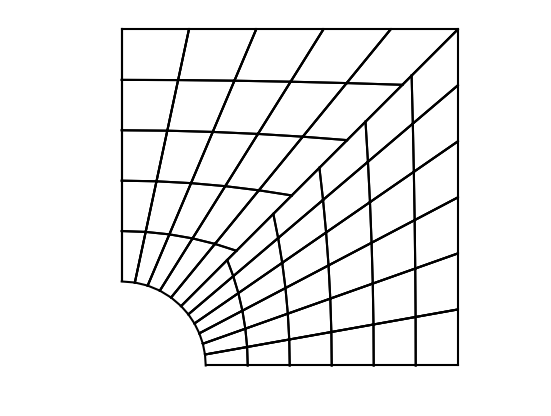

(-0.05000000000000998, 1.0500000000000005, -0.05, 1.05)

In [4]:
using PyPlot

function plot_mesh(mesh, elset_names...)
    fig = figure()
    for elset_name in elset_names
        for element_id in mesh.element_sets[elset_name]
            element_conn = mesh.elements[element_id]
            n = length(element_conn)
            for j in 0:n
                j1 = mod(j, 4) + 1
                j2 = mod(j+1, 4) + 1
                c1 = element_conn[j1]
                c2 = element_conn[j2]
                x1, y1 = mesh.nodes[c1]
                x2, y2 = mesh.nodes[c2]
                plot([x1, x2], [y1, y2], "-k")
            end
        end
    end
    axis("equal")
    axis("off")
end

plot_mesh(mesh, :A, :B)

Create elements and add properties to elements

In [5]:
A_elements = create_elements(mesh, "A")
A1_elements = create_elements(mesh, "A1")
A2_elements = create_elements(mesh, "A2")
A3_elements = create_elements(mesh, "A3")
A4_elements = create_elements(mesh, "A4")
B_elements = create_elements(mesh, "B")
B1_elements = create_elements(mesh, "B1")
B2_elements = create_elements(mesh, "B2")
B3_elements = create_elements(mesh, "B3")
B4_elements = create_elements(mesh, "B4")

update!(A_elements, "youngs modulus", 100.0)
update!(A_elements, "poissons ratio", 0.3)
update!(B_elements, "youngs modulus", 100.0)
update!(B_elements, "poissons ratio", 0.3)
update!(A1_elements, "displacement 1", 0.0)
update!(B1_elements, "displacement 2", 0.0)
update!(A2_elements, "displacement traction force 2", -100.0)
update!(B2_elements, "displacement traction force 1", -100.0)

length(A_elements), length(B_elements)

(25, 36)

Create problems for both parts, symmetry boundary condition and traction

In [6]:
A = Problem(Elasticity, "A", 2)
B = Problem(Elasticity, "B", 2)
A.properties.formulation = :plane_stress
B.properties.formulation = :plane_stress
add_elements!(A, A_elements)
add_elements!(B, B_elements)

tractions = Problem(Elasticity, "tractions", 2)
tractions.properties.formulation = :plane_stress
add_elements!(tractions, A2_elements)
add_elements!(tractions, B2_elements)

bc = Problem(Dirichlet, "fixed", 2, "displacement")
add_elements!(bc, A1_elements)
add_elements!(bc, B1_elements);

Create mesh tie contact between bodies using Mortar method

In [7]:
tie = Problem(Mortar2D, "tie", 2, "displacement")
add_slave_elements!(tie, A3_elements)
add_master_elements!(tie, B3_elements)

Create linear quasistatic analysis and run

In [8]:
analysis = Analysis(Linear)
add_problems!(analysis, [A, B, tractions, bc, tie])
xdmf = Xdmf("results"; overwrite=true)
add_results_writer!(analysis, xdmf)
run!(analysis)
write_results!(analysis, 0.0)
close(xdmf.hdf)

INFO: Solving problems ...
INFO: Solved problems in 1.56 seconds using solver 3.
INFO: Solution norms = (6.382082834115484, 325.4193353814148).
INFO: Updating problems ...
INFO: resizing solution vector u
INFO: resizing lagrange multiplier vector la
INFO: resizing solution vector u
INFO: resizing lagrange multiplier vector la
INFO: resizing solution vector u
INFO: resizing lagrange multiplier vector la
INFO: resizing solution vector u
INFO: resizing lagrange multiplier vector la
INFO: resizing solution vector u
INFO: resizing lagrange multiplier vector la
INFO: Updated problems in 0.28 seconds.
INFO: Xdmf: storing fields String["displacement"] of problem A at time 0.0
INFO: Xdmf: Domain not found, creating.
INFO: Xdmf: Temporal collection not found, creating.
INFO: Xdmf: SpatialCollection for time 0.0 not found, creating.
INFO: Xdmf: Creating Grid for problem A
INFO: Xdmf: Creating geometry, type = XY, number of nodes = 36
INFO: Xdmf: Saving topology of 25 elements total, 1 different e

Results (displacement magnitude)

![results](2d_plane_stress_with_tie_contact/results.png "Displacement")